<a href="https://colab.research.google.com/github/akhil14shukla/Crypto-Prediction/blob/master/main_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto-currency Price Prediction using LSTM (Long-Short Term Memory) Model

We will **predict the price of the next day using the data of past few days**(exact number of past few days depends on the data). <br>Suppose we find that our price is highly correlated to the prices of last 7 days. Then, we will use the price of last 7 days to predict the price of tomorrow/next day.<br>
But for predicting the price of day after tomorrow, we will be needing the price of tomorrow. This problem is not considered in this notebook, cause this notebook was created with the aim to predict the price of tomorrow.<br><br>
But we can still solve this problem using two ways:<br><br>
1. Directly training the model to predict the price of day after tomorrow rather than tomorrow, using the past data. <br><br>
2. Using the predicted price of tomorrow as historical data, and using it to predict the price of day after tomorrow, and adding this to historical dataset, to predict the price of next day, and so on.<br><br>

_Notes - _<br>
_1. The error will be a bit greater in the above methods_<br>
_2. Past data and historical data are used synonymously_


Notebook is divided into Sections :<br>
1. Data Import<br>
2. Understanding the distribution of the data<br>
3. Data Transformation<br>
4. Model Building and Training<br>
6. Cross-Validating the model<br><br>
7. Notes<br>
8. Playground

In [52]:
# Importing the required libraries
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_datareader as web
import datetime as dt 
!pip install yfinance
import yfinance as yf
!pip install sktime
import sktime
import pandas_datareader.data as pdr
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Dropout, LSTM, LayerNormalization,Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import backend
from sklearn.metrics import mean_squared_error
# from pycaret.regression import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
tf.debugging.set_log_device_placement(True)


## Data Import

Choose the cryptocurrency we want to predict, and the period of time whose data we want to collect.

In [54]:
crypto_currency = 'BNB'
against_currency ='USD'
start = dt.datetime(2020,1,1)
end = dt.datetime.now()

Extracting the above chosen data using Yahoo-Finance API

In [55]:
yf.pdr_override()
data = pdr.get_data_yahoo("ETH-USD", start, end)
# Importing the extracted data in PyCaret
# df = setup(data,target = "Close",ignore_features=["Volume","Adj Close"], use_gpu=True,imputation_type='iterative', feature_ratio=True, feature_interaction=True, normalize=True, transform_target=True)           

[*********************100%***********************]  1 of 1 completed


## Understaning the distribution of the data

In [56]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330
2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256
2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358
2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515
2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353
2020-01-06,136.305542,144.328186,136.079636,144.304153,144.304153,9093747121
2020-01-07,144.311996,145.001770,140.488876,143.543991,143.543991,9257954672
2020-01-08,143.487823,146.828003,138.268204,141.258133,141.258133,9387194957
2020-01-09,141.155777,141.393982,136.236404,138.979202,138.979202,7697325348


Plotting Closing price of the cryptocurrency

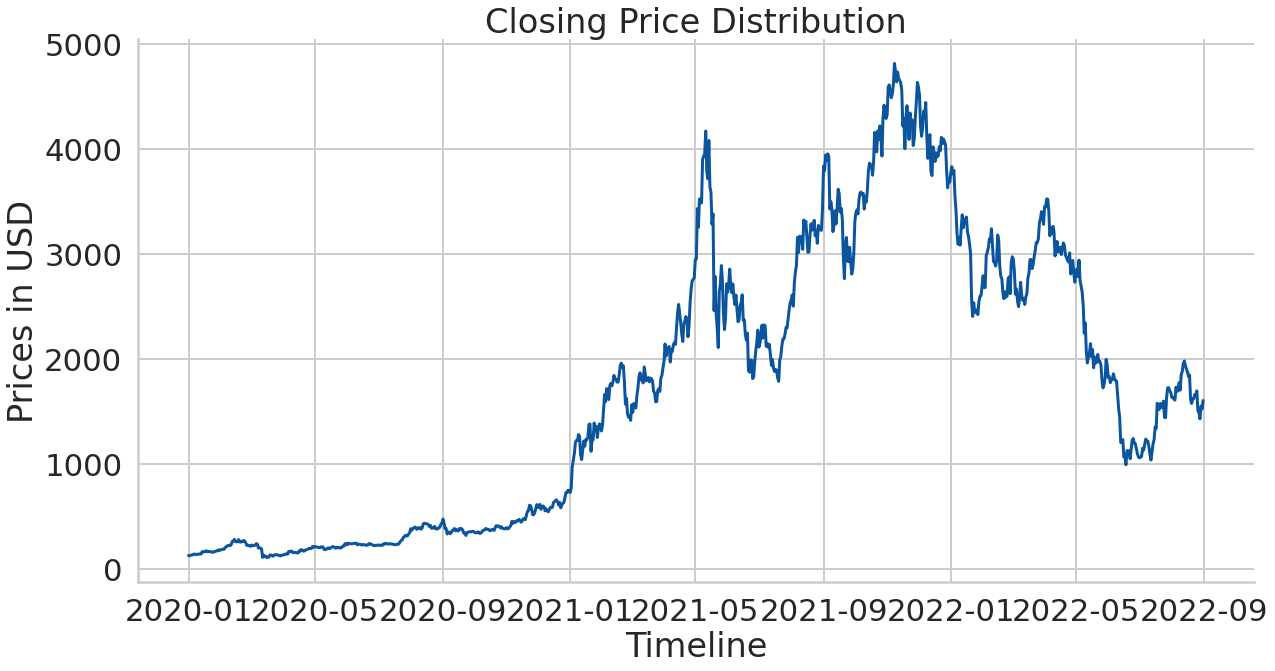

In [57]:
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid",context="poster", font_scale=1.4)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(data["Close"])
sns.despine(top=True,right=True,bottom=False, left=False)
plt.xlabel("Timeline")
plt.ylabel("Prices in USD")
plt.title("Closing Price Distribution")
plt.show()


Doing ADF test on the original series

In [58]:
adf_orig = adfuller(data["Close"])
print('ADF Statistic: %f' % adf_orig[0])
print('p-value: %f' % adf_orig[1])

ADF Statistic: -1.538119
p-value: 0.514577


In [59]:
# Distribution of our target variable -> Close
# from scipy.special import boxcox1p
# plt.plot(np.array(final_data["Close"]))

### Checking if our series is affected by past values

Text(0, 0.5, 'Correlation')

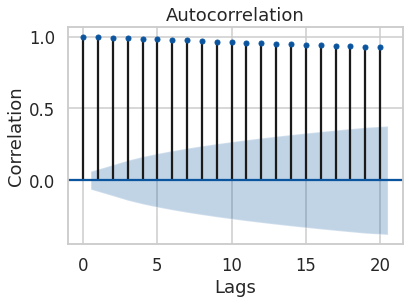

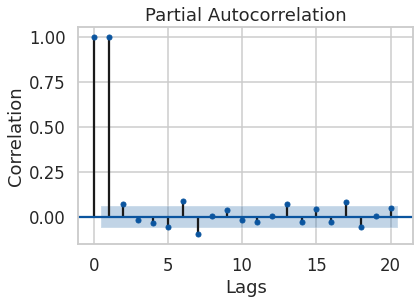

In [60]:
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid",context="talk")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close'], lags=20)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plot_pacf(data['Close'], lags=20)
plt.xlabel("Lags")
plt.ylabel("Correlation")

From the above plots, lags are highly correlated to the value at hand. This will be useful while preparing the data for the model, and we will pass tha value, based on the above Observation.

From here, I tried various plots of interactions and transformations of the attributes.

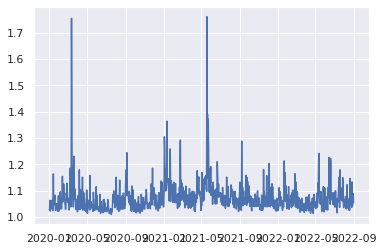

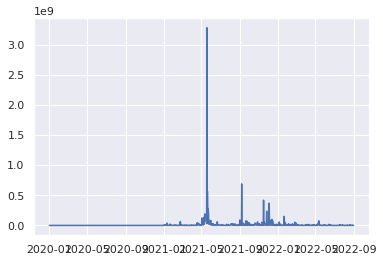

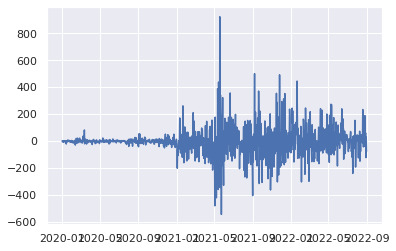

In [61]:
plt.figure() 
sns.set()
plt.plot(data["High"]/data["Low"])
plt.figure()
plt.plot((np.power(data["High"]-data["Low"],3)))
plt.figure()
plt.plot(data["Open"]-data["Close"])

## Data Cleaning and Transformation

In [62]:
print(data.isnull().sum())     # checking for missing values

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Section for trying sktime library, if it can help us transform the Time-Series

In [63]:
# from sktime.utils.plotting import plot_series
# from sktime.transformations.panel.rocket import Rocket
# y = data["Close"]
# x = data[data.columns]
# x.drop(["Close","Volume"],axis=1,inplace=True)
# plot_series(data["Close"])
# rocket = Rocket()
# rocket.fit(np.array(x))
# x_t = rocket.transform(np.array(x))

### Defining methods for transforming time-series data

In [64]:
def difference(data, interval=1):
    ind = data.index[interval:]
    data = np.array(data)
    tmp= [data[i] - data[i - interval] for i in range(interval, len(data))]
    tmp = pd.DataFrame(tmp, index=ind)
    return tmp
def invert_difference(orig_data, diff_data, interval=1):
    last = orig_data
    for x in range(len(diff_data)):
        diff_data[x] = diff_data[x] + last
        last = diff_data[x]
    return diff_data

from scipy.stats import boxcox
# fd =(boxcox1p(final_data["Close"]))#*np.log(boxcox1p(final_data["Close"],-1))
# plt.plot(fd)

The idea here is to store the data at each step, without losing/replacing it. <br>Thus, creating new variables wherever required to store the new/transformed data in the new variable.

Adding new Attributes to the dataset, based on the plots and Observations of the previous section.<br>Some Transformations are commented, cause they were not a suitable fit, but might be useful later.

In [65]:
final_data = pd.DataFrame()
final_data["Close_Open"] = np.power(data['Close']-data['Open'],3)
final_data["High_Low"] = data['High']/data['Low']
final_data['t1'] = (np.power(data["High"]-data["Low"],3))
final_data['Close'] = data['Close']
store = final_data
# final_data = pd.DataFrame(difference((final_data)))
final_data.head()
# # scaler = PowerTransformer(method="yeo-johnson", standardize=True)
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler_close = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(final_data.iloc[:,:3])
# scaled_close = scaler_close.fit_transform(final_data.iloc[:,3:4])
# scaled_data = np.concatenate((scaled_data,scaled_close),axis=1)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)

,Close_Open,High_Low,t1,Close
Date,,,,
2020-01-01,1.607126,1.028151,48.112162,130.802002
2020-01-02,-39.646892,1.030445,57.741957,127.410179
2020-01-03,308.976737,1.063752,524.385661,134.171707
2020-01-04,0.731064,1.022641,27.329687,135.069366
2020-01-05,1.748303,1.032319,83.143222,136.276779


In [66]:
final_data

,Close_Open,High_Low,t1,Close
Date,,,,
2020-01-01,1.607126e+00,1.028151,4.811216e+01,130.802002
2020-01-02,-3.964689e+01,1.030445,5.774196e+01,127.410179
2020-01-03,3.089767e+02,1.063752,5.243857e+02,134.171707
2020-01-04,7.310635e-01,1.022641,2.732969e+01,135.069366
2020-01-05,1.748303e+00,1.032319,8.314322e+01,136.276779
...,...,...,...,...
2022-08-27,-4.709498e+03,1.043229,2.484675e+05,1491.395020
2022-08-28,-2.232003e+05,1.052598,4.260166e+05,1430.547363
2022-08-29,1.842677e+06,1.090060,2.125848e+06,1553.037354


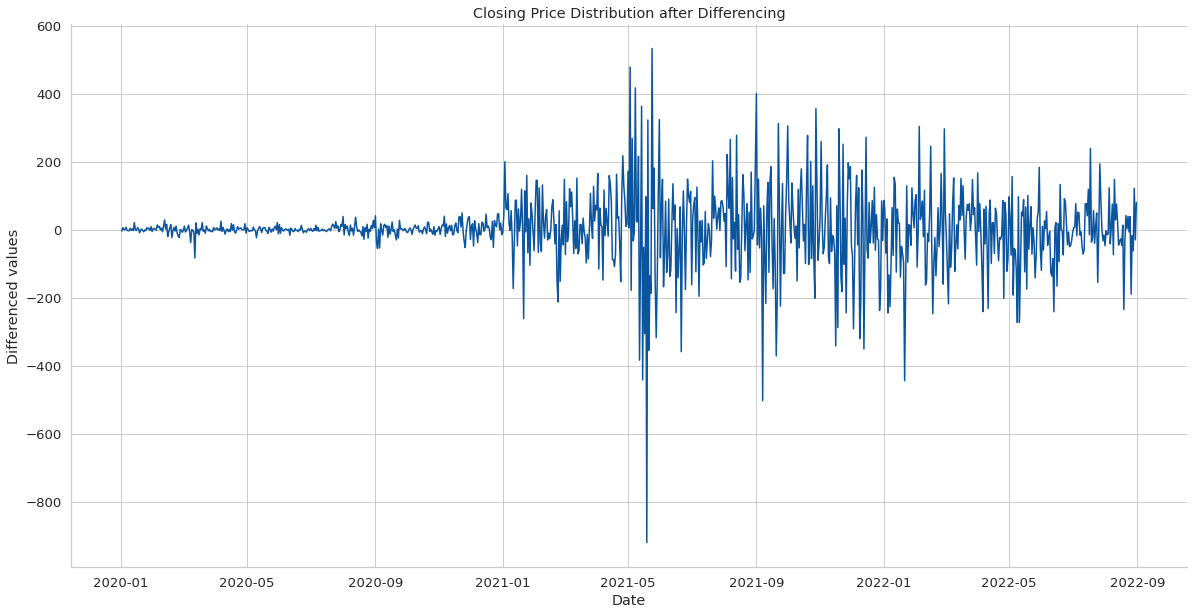

In [67]:
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid", font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(data.index[1:],final_data['Close'][1:].values-final_data['Close'][:-1].values)
sns.despine(top=True,right=True,bottom=False, left=False)
# plt.xlabel("")
plt.ylabel("Differenced values")
plt.title("Closing Price Distribution after Differencing")
plt.xlabel("Date")
plt.show()

In [68]:
adf_transf = adfuller(final_data['Close'][1:].values-final_data['Close'][:-1].values)
print('ADF Statistic: %f' % adf_transf[0])
print('p-value: %f' % adf_transf[1])

ADF Statistic: -11.887419
p-value: 0.000000


In [69]:
final_data.corr()

,Close_Open,High_Low,t1,Close
Close_Open,1.000000,-0.368287,-0.876792,-0.014902
High_Low,-0.368287,1.000000,0.523770,0.033228
t1,-0.876792,0.523770,1.000000,0.114018
Close,-0.014902,0.033228,0.114018,1.000000


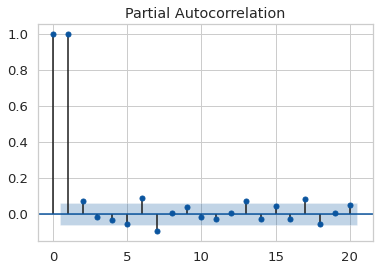

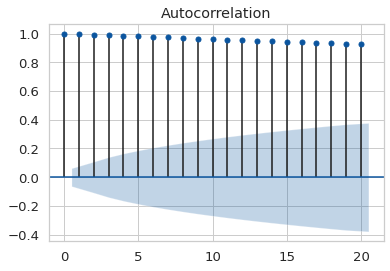

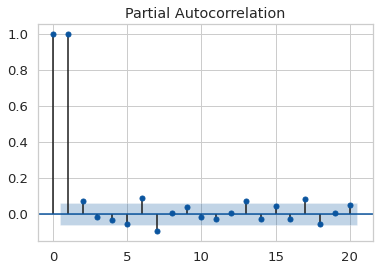

In [70]:
plot_acf(final_data['Close'], lags=20)
plot_pacf(final_data['Close'], lags=20)

In [71]:
# np.array(difference(scaled_data)).shape

### Preparing the data

The data is in 3 dimensions.<br> <br>First Dimension - It denotes the number of observations. Each value of this dimension (the values are in 2-dimension) is the input to our model, corresponding to which we have final value.<br> <br>Second Dimension - It denotes the past values, which we will be using to predict. The length of this dimension, shows how many past values/observations we will be feeding to our model.<br> <br>Third Dimension - It shows the attributes that we think affect our future value or might increase the performance of our model.<br><br> Suppose _i_,_j_,_k_ as indices and _data_ as our final 3-Dimensional Dataset. Then _data\[i\]_ , denotes a single 2-D observation consisting of values of previous days. Then, _data\[i\]\[j\]_ denotes a 1-D value of one of the previous days from our previous  2-D _data\[i\]_. _data\[i\]\[j\]\[k\]_ denotes value of one attribute from our previous 1-D _data\[i\]\[j\]_ which denoted all the attributes of one of the past days. 

**_Note to self : Might upload a image for better understanding of the readers._**

In [72]:
# Preparing the Data
prediction_days = 200
future_days=0
# store = scaled_data
# scaled_data = np.array(difference(scaled_data))
x_train, y_train = [], []
scaled_data=np.array(final_data)
for x in range(prediction_days, len(scaled_data)-future_days-prediction_days-122):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days:x+122,scaled_data.shape[1]-1])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(452, 200, 4)

In [73]:
# y_train = y_train.reshape(449,122,1)
y_train.shape

(452, 122)

In [74]:
len(store)

974

In [75]:
len(scaled_data)

974

## Model Building and Training

In [76]:
# custom metric for our model, only to monitor our model while training
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [77]:
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = np.array(y_true), np.array(y_pred)
    return backend.mean(backend.abs((y_true - y_pred) / y_true)) * 100

Building LSTM using TensorFlow. At the end compiling and training the model. <br><br>
The hyperparameters need to be more precisely tuned, but so far they seem to work fine. We can add more layers to improve the model, and this is an **endless process**.

In [78]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Create 2 virtual GPUs with 1GB memory each
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#          tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [79]:
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)
# with strategy.scope():
#   #creating neural netowrk
#   # from attention_decoder import AttentionDecoder

#   model = Sequential()                # could make units 50, for better prediction
#   # model.add(LayerNormalization())     # Normalizing the input data 
#   # First LSTM layer
#   model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="relu",unroll=True))
#   # model.add(Dropout(0.1))    # Removing some of the data from the previous layer to avoid overfitting
#   model.add(BatchNormalization())
#   model.add(LSTM(units=50, activation="relu",unroll=True,return_sequences=True))#, return_sequences=True))    # Second LSTM Layer
#   # model.add(Dropout(0.1))
#   model.add(Activation(activation="relu"))
#   # model.add(BatchNormalization())
#   # model.add(LSTM(units=50, return_sequences=True))
#   # # model.add(Dropout(0.1))
#   # model.add(BatchNormalization())
#   # model.add(LSTM(units=50, return_sequences=True))
#   # # model.add(Dropout(0.1))
#   # model.add(BatchNormalization())
#   model.add(LSTM(units=50, return_sequences=True))
#   # model.add(Dropout(0.1))
#   model.add(BatchNormalization())
#   model.add(LSTM(units=50, return_sequences=False))
#   # model.add(Dropout(0.1))
#   # model.add(LSTM(units=50, return_sequences=True))
#   # model.add(Dropout(0.1))
#   # model.add(LSTM(units=50, return_sequences=True))
#   # model.add(Dropout(0.1))
#   # model.add(LSTM(units=50, return_sequences=True))
#   # model.add(Dropout(0.1))
#   model.add(Activation(activation="relu"))
#   model.add(BatchNormalization())
#   # model.add(LSTM(units=50))
#   # model.add(Dropout(0.1))
#   # model.add(BatchNormalization())
#   ## 
#   # model.add(Dropout(0.1))
#   # model.add(LSTM(units=50,activation="relu"))
#   # model.add(Dense(units=500, activation="relu"))
#   # model.add(Dropout(0.2))

#   model.add(Dense(units=122,activation='linear'))  # Final LSTM Layer of unit=1, cause we have just one Output, that is, Closing Price
#   model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1),metrics=[rmse])   # Compiling, optimizer and loss can be changed to optimize the model for our specific purpose
#   model.fit(x_train,y_train, epochs=10, batch_size=10)

In [109]:
#creating neural netowrk
# from attention_decoder import AttentionDecoder

model = Sequential()                # could make units 50, for better prediction
# model.add(LayerNormalization())     # Normalizing the input data 
# First LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="softplus",unroll=True))
# model.add(Dropout(0.1))    # Removing some of the data from the previous layer to avoid overfitting
model.add(BatchNormalization())
model.add(LSTM(units=50, activation="softplus",unroll=True,return_sequences=True))#, return_sequences=True))    # Second LSTM Layer
# model.add(Dropout(0.1))
# model.add(Activation(activation="relu"))
# model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Activation(activation="relu"))
# model.add(BatchNormalization())
# model.add(LSTM(units=50))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
## 
# model.add(Dropout(0.1))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=500, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(units=122,activation='relu'))  # Final LSTM Layer of unit=1, cause we have just one Output, that is, Closing Price
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1),metrics=[rmse])   # Compiling, optimizer and loss can be changed to optimize the model for our specific purpose
model.fit(x_train,y_train, epochs=10, batch_size=10)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/devic

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/devic

## Cross-Validating the model

Extracting the data for test dataset, and performing the same operation as performed on training data. And, combining the dataset, and from this combined dataset extracting the data which will be given as input to the model.<br><br>
The reason for the above process is, to predict the first few predictions, we also need past data that is available in training dataset, so we combine that required data with our test data and then pass it to the model.
         

In [132]:
test_start = dt.datetime.now()-dt.timedelta(days=121)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo("ETH-USD", test_start, test_end)

final_test = pd.DataFrame()
final_test['Close_Open'] = np.power(test_data['Close']-test_data['Open'],3)
final_test['High_Low'] = test_data['High']/test_data['Low']
final_test['t1'] = np.power(test_data["High"]-test_data["Low"],3)
final_test['Close'] = test_data['Close']

# total_dataset = pd.concat((store,final_test),axis=0)
model_inputs = (store[len(store) - len(test_data)-prediction_days:-len(test_data)])
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs

store_model_inputs = (model_inputs)
model_inputs = np.array((model_inputs))

# model_inputs = np.concatenate((scaler.transform(model_inputs[:,:3]), scaler_close.transform(model_inputs[:,3:4])),axis=1)
# actual_prices = (store_model_inputs[prediction_days+1:,3])# difference(np.log10((test_data['Close']))).to_numpy()
# orig_recover_data = np.concatenate((np.array(store_model_inputs[prediction_days, store_model_inputs.shape[1]-1]).reshape(-1,1),actual_prices),axis=0)


x_test = []
# for x in range(prediction_days, len(model_inputs)):
#     x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array([np.array(final_data[-prediction_days-122:-122])])
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

[*********************100%***********************]  1 of 1 completed


In [138]:
# np.array(prediction_prices).shape
# a = (1,2,3)
# a[3:]
# # np.array(store_model_inputs[prediction_days, store_model_inputs.shape[1]-1]).reshape(-1,1)
x_test = np.array([model_inputs])

In [139]:
prediction_prices = model.predict(x_test)
print(prediction_prices.shape)
# prediction_prices = scaler_close.inverse_transform(prediction_prices)
# prediction_prices = invert_difference(total_dataset.iloc[-123,3],prediction_prices)

len(prediction_prices)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

1

In [140]:
prediction_prices

array([[26.572767, 25.777393,  0.      , 27.009085, 25.604519, 26.0399  ,
        26.033865, 25.521318, 25.033579, 27.302948, 24.486988, 27.688694,
        25.913305, 26.227417, 26.091223, 25.644627, 26.456606, 27.063492,
         0.      ,  0.      ,  0.      , 26.753767, 25.809505, 27.505491,
        26.245073,  0.      , 24.274658, 27.154253, 26.40322 , 24.302319,
        25.944431, 24.463747, 26.150265,  8.471256, 24.911324, 25.547781,
        26.745523, 25.349876, 25.226171, 24.497705,  0.      , 25.88307 ,
        26.63011 , 26.107271, 26.40622 , 26.166   , 26.972414, 25.446724,
        25.909428, 25.858025, 25.95819 , 26.945463,  0.      , 25.74558 ,
        25.76722 , 24.505445, 21.841389, 25.8435  ,  0.      ,  0.      ,
        25.612692, 24.582184, 26.589304, 27.23973 , 26.603565, 26.0778  ,
        27.705645, 26.014832, 26.241879, 27.40809 , 27.35587 , 25.486952,
        26.004606,  0.      , 26.306656, 27.088385, 26.09037 ,  0.      ,
        24.403572, 25.821032, 25.99157

Predicting the prices using x_test, and comparing it with the actual prices

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

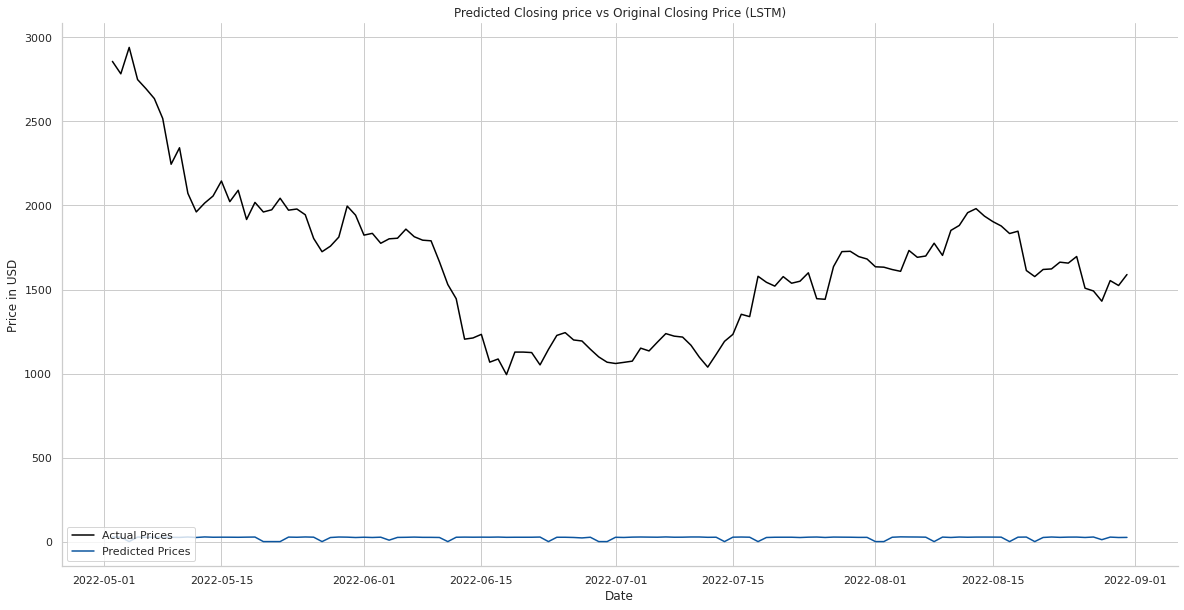

In [141]:
prediction_prices = model.predict(x_test)
# prediction_prices = scaler_close.inverse_transform(prediction_prices)
# prediction_prices = invert_difference(total_dataset.iloc[-123,3],prediction_prices)
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(20,10))
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(test_data.index[0:],total_dataset.iloc[-122:,3],color='black', label='Actual Prices')
plt.plot(test_data.index[0:],prediction_prices[0], label='Predicted Prices')
plt.title("Predicted Closing price vs Original Closing Price (LSTM)")
plt.xlabel('Date')
plt.ylabel('Price in USD')
sns.despine(top=True,right=True,bottom=False, left=False)# prediction_prices = scaler.inverse_transform(prediction_prices)
plt.legend(loc='lower left')
plt.show()

In [142]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [146]:
# rmse(prediction_prices[0],total_dataset.iloc[-122:,3])
np.sqrt(np.mean(backend.square(prediction_prices[0] - test_data['Close'][:]), axis=-1))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Square in device /job:localhost/replica:0/task:0/device:GPU:0


1681.2000555301122

In [147]:
mean_absolute_percentage_error(test_data['Close'][:],prediction_prices[0])

98.55521496126717

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

ValueError: ignored

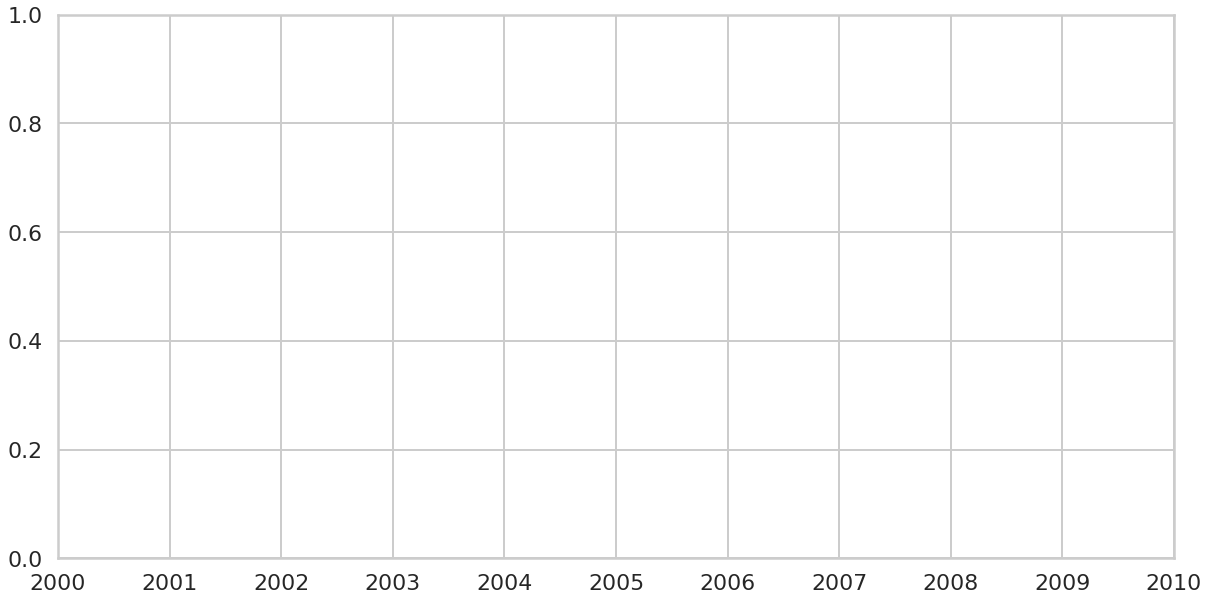

In [106]:
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid",context="poster", font_scale=1)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_data.index[0:], model.predict(x_test))
sns.despine(top=True,right=True,bottom=False, left=False)# prediction_prices = scaler.inverse_transform(prediction_prices)
plt.ylabel("Output from the Model")
plt.xlabel("Date")
plt.title("Direct Untransformed output from the model")
plt.show()

Comparing the RMSE scores of predicting on Training dataset vs Test Dataset.This will help us to check overfitting and improving our models.

IndexError: index 849 is out of bounds for axis 0 with size 849

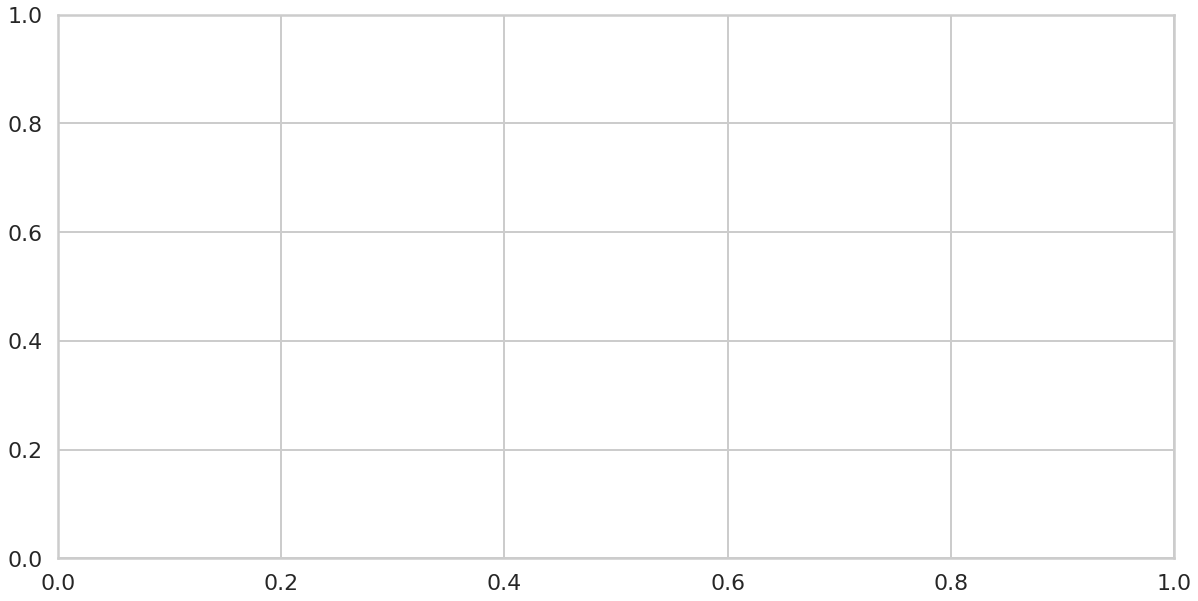

In [ ]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
# (prediction_prices)
# plottiong training dataset  
sns.set(palette=sns.color_palette("Blues_r"),style="whitegrid",context="poster", font_scale=1)
fig, ax = plt.subplots(figsize=(20,10))
predict_train, = plt.plot(data.index[8:], invert_difference(np.array(store)[:-7,3],scaler_close.inverse_transform(model.predict(x_train))),label="Predicted Prices")
actual_train, = plt.plot(data.index[8:], invert_difference(np.array(store)[:-7,3],scaler_close.inverse_transform(y_train.reshape(-1,1))),color="black",label="Actual Prices")
train = mean_squared_error(invert_difference(np.array(store)[:-7,3],scaler_close.inverse_transform(model.predict(x_train))),invert_difference(np.array(store)[:-7,3],scaler_close.inverse_transform(y_train.reshape(-1,1))), squared=False )
test = mean_squared_error(invert_difference(orig_recover_data,scaler_close.inverse_transform(model.predict(x_test))),actual_prices,squared=False)
sns.despine(top=True,right=True,bottom=False, left=False)# prediction_prices = scaler.inverse_transform(prediction_prices)

plt.ylabel("Price in USD")
plt.xlabel("Date")
plt.title("Predicted vs Original Closing Price for training dataset")
plt.legend(handles = [predict_train, actual_train], loc='lower right')
plt.show()
print("Test Data (RMSE) : ", test);
print("Train Data (RMSE) : ", train);
# plt.plot(model.predict(x_train))
# plt.plot(y_train)

In [ ]:
tf.keras.utils.plot_model(model,  show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Notes
for 1000 epochs, model is overfitting, 500 seems fine to me. Might decrease the epochs from 500
Optimizer and loss are alright to i guess.
activation function is next (marked in to-do in github projects)

## Playground for trying various combination before they are finally incorporated into the notebook

In [ ]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

SyntaxError: unmatched ')' (2051972328.py, line 1)

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

/tmp/ipykernel_52956/3179714833.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pd.Series(np.array(boxcox(data['Close'])))


0    [59.688153595200404, 60.69915504821542, 61.343...
1                                             1.178539
dtype: object

In [ ]:
# plt.plot(data['Open'])
# plt.plot(data['Close'])
plt.plot(data['High'] - data['Low'])
plt.plot(data['Close'] - data['Open'])
# plt.plot(data['Close'] - data['High'])
# plt.plot(data['Close'] - data['Low'])
# plt.plot(data['Low'])

In [ ]:
# #creating neural netowrk  Good Model
# model = Sequential()                # could make units 50, for better prediction
# model.add(LSTM(units=500, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu" ))
# # model.add(Dropout(0.2))
# model.add(LSTM(units=500, activation="relu"))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=50,activation="relu"))
# # model.add(Dense(units=100, activation="relu"))
# # model.add(Dropout(0.2))

# model.add(Dense(units=1,activation="relu"))
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
# model.fit(x_train,y_train, epochs=100, batch_size=10)

In [ ]:
# best model till now
model = Sequential()                # could make units 50, for better prediction
# model.add(LayerNormalization())     # Normalizing the input data 
# First LSTM layer
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]),activation="relu",unroll=True))
# model.add(Dropout(0.1))    # Removing some of the data from the previous layer to avoid overfitting
model.add(BatchNormalization())
model.add(LSTM(units=50, activation="relu",unroll=True,return_sequences=True))#, return_sequences=True))    # Second LSTM Layer
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=50, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(units=50))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
## 
# model.add(Dropout(0.1))
# model.add(LSTM(units=50,activation="relu"))
# model.add(Dense(units=500, activation="relu"))
# model.add(Dropout(0.2))

model.add(Dense(units=1))  # Final LSTM Layer of unit=1, cause we have just one Output, that is, Closing Price
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1),metrics=[rmse])   # Compiling, optimizer and loss can be changed to optimize the model for our specific purpose
model.fit(x_train,y_train, epochs=80, batch_size=10)

Epoch 1/80
55/55 [==============================] - 11s 16ms/step - loss: 0.2063 - rmse: 0.4907
Epoch 2/80
55/55 [==============================] - 1s 16ms/step - loss: 0.0376 - rmse: 0.2155
Epoch 3/80
55/55 [==============================] - 1s 16ms/step - loss: 0.0235 - rmse: 0.1584
Epoch 4/80
55/55 [==============================] - 1s 17ms/step - loss: 0.0180 - rmse: 0.1358
Epoch 5/80
55/55 [==============================] - 1s 16ms/step - loss: 0.0120 - rmse: 0.1178
Epoch 6/80
55/55 [==============================] - 1s 17ms/step - loss: 0.0095 - rmse: 0.1042
Epoch 7/80
55/55 [==============================] - 1s 16ms/step - loss: 0.0069 - rmse: 0.0848
Epoch 8/80
55/55 [==============================] - 1s 17ms/step - loss: 0.0089 - rmse: 0.0974
Epoch 9/80
55/55 [==============================] - 1s 17ms/step - loss: 0.0057 - rmse: 0.0819
Epoch 10/80
55/55 [==============================] - 1s 16ms/step - loss: 0.0064 - rmse: 0.0835
Epoch 11/80
55/55 [=============================